# Imports #

In [252]:
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression , Lasso , Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.svm import SVR, LinearSVR

import matplotlib.pyplot as plt

import joblib

# Preprocessing #

In [253]:
pricing = pd.read_csv('get_around_pricing_project.csv',index_col=0)

In [ ]:
# Feature engineering:

# pricing['mileage_2'] = pricing['mileage']**2
# pricing['mileage_ln'] = np.log(pricing['mileage'])
# pricing['engine_power_2'] = pricing['engine_power']**2
# pricing['engine_power_3'] = pricing['engine_power']**3
# pricing['mileage_engine_power'] = pricing['mileage']*pricing['engine_power']
# pricing['mileage_2_engine_power'] = pricing['mileage']**2 * pricing['engine_power']

# Remove missing values created by the logarithm:
# pricing.dropna(subset=['mileage_ln'], inplace=True)

print('All feature engineering were tested on XGBoost, the best model, and all of the decreased the R² for test.')

In [254]:
# Separate target variable Y from features X

print()
target_variable = "rental_price_per_day"
print("Target variable: ",target_variable)
Y = pricing.loc[:,target_variable]
print('Y : ')
print(Y.head())

features_list = pricing.drop(target_variable,axis=1).columns.tolist()
print("Features list: ",features_list)
X = pricing.loc[:,features_list]
print('X :')
print(X.head())
categorical_indices = [0,3,4,5,6,7,8,9,10,11,12]
numeric_indices = [1,2]


Target variable:  rental_price_per_day
Y : 
0    106
1    264
2    101
3    158
4    183
Name: rental_price_per_day, dtype: int64
Features list:  ['model_key', 'mileage', 'engine_power', 'fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']
X :
  model_key  mileage  engine_power    fuel paint_color     car_type  \
0   Citroën   140411           100  diesel       black  convertible   
1   Citroën    13929           317  petrol        grey  convertible   
2   Citroën   183297           120  diesel       white  convertible   
3   Citroën   128035           135  diesel         red  convertible   
4   Citroën    97097           160  diesel      silver  convertible   

   private_parking_available  has_gps  has_air_conditioning  automatic_car  \
0                       True     True                 False          False   
1                       True     True        

In [255]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [256]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first',categories='auto',handle_unknown='ignore')) # first column will be dropped to avoid creating correlations between features, auto for representations of all catego
    ])

# Applying pipeline on X variables depending on columns
feature_encoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = feature_encoder.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = feature_encoder.transform(X_test) # Don't fit again !!
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
     model_key  mileage  engine_power    fuel paint_color car_type  \
4550       BMW   132485           135  diesel       white      suv   
1237   Citroën   131121           135  diesel       black   estate   
3158   Renault   209216           135  diesel        grey    sedan   
900    Peugeot   148986           100  diesel       black   estate   
933    Citroën   170500           135  diesel       black   estate   

      private_parking_available  has_gps  has_air_conditioning  automatic_car  \
4550                       True     True                 False          False   
1237                      False     True                 False          False   
3158                       True     True                 False          False   
900                        True     True                 False          False   
933                        True     True                 False          False   

      has_getaround_connect  has_speed_regulator  

c:\Users\elodi\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



In [257]:
Y_train = Y_train.to_numpy().reshape(-1,1)
Y_test = Y_test.to_numpy().reshape(-1,1)

scaler = StandardScaler()

print("Preprocessing Y_train and Y_test")
Y_train = scaler.fit_transform(Y_train)
print(Y_train[0:5,:])
Y_test = scaler.transform(Y_test)
print(Y_test[0:5,:])

Preprocessing Y_train and Y_test
[[ 0.28870358]
 [ 0.19972448]
 [ 0.14040508]
 [-0.30449044]
 [-0.63074716]]
[[-0.71972626]
 [ 0.97087671]
 [-1.16462178]
 [-1.90611432]
 [-0.57142776]]


# MODELS #

In [258]:
# Models to be tested

models = [
    {
        'name': 'Linear Regression',
        'model': LinearRegression(),
        'params': {}
    },
    {
        'name': 'Lasso',
        'model': Lasso(),
        'params': {'alpha': [0.0, 0.1, 0.5, 1.0, 2, 3, 5, 10]}  # Adjusted alpha values
    },
    {
        'name': 'Ridge',
        'model': Ridge(),
        'params': {'alpha': [0.0, 0.1, 0.5, 1.0, 2, 3, 5, 10]}  # Adjusted alpha values
    },
    {
        'name': 'Decision Tree',
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [1, 2, 3, 4, 6, 8, 10, 12, 15, 20],  # Adjusted max_depth values
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [1, 2, 4, 8]
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestRegressor(),
        'params': {
            'max_depth': [2, 4, 6, 8, 10],
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [2, 4, 8],
            'n_estimators': [10, 20, 40, 60, 80, 100, 150, 200]  # Adjusted n_estimators values
        }
    },
    {
        'name': 'SVR linear',
        'model': SVR(kernel='linear'),
        'params': {'C': [0.1, 1, 10]}  # Adjusted C values
    },
    {
        'name': 'SVR poly',
        'model': SVR(kernel='poly'),
        'params': {'degree': [2, 3, 4]}  # Adjusted degree values
    },
    {
        'name': 'SVR rbf',
        'model': SVR(kernel='rbf'),
        'params': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}  # Adjusted C and gamma values
    },
    {
        'name': 'XGBoost',
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 150, 200],  # Adjusted n_estimators values
            'learning_rate': [1.0, 0.5, 0.1],
            'max_depth': [3, 4, 5],  # Additional parameter to adjust
            'min_child_weight': [1, 2, 3],  # Additional parameter to adjust
            'gamma': [0, 0.1, 0.2]  # Additional parameter to adjust
        }
    },
]


In [ ]:
results = []

# Iterate over models, doing a gridsearch for choosing the best params for each model. 
for model_info in models:
    model_name = model_info['name']
    model = model_info['model']
    params = model_info['params']
    grid_search = GridSearchCV(model, params, cv=3)
    grid_search.fit(X_train, Y_train)

    # Evaluation and storage of performance in a variable "results"
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    train_r2 = r2_score(Y_train, train_preds)
    test_r2 = r2_score(Y_test, test_preds)
    results.append({'Model': model_name, 'Train R2': train_r2, 'Test R2': test_r2, 'Best Model': best_model, 'Best Params': best_params, 'Train Preds':train_preds, 'Test Preds':test_preds})


In [260]:
# Results storage in a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.iloc[:,:3]
sorted_results_df = results_df.sort_values(by='Test R2', ascending=False)
print(sorted_results_df)

               Model  Train R2   Test R2
8            XGBoost  0.877933  0.777765
4      Random Forest  0.879949  0.756269
7            SVR rbf  0.762156  0.722240
6           SVR poly  0.753238  0.715685
5         SVR linear  0.702878  0.689473
0  Linear Regression  0.715670  0.689282
1              Lasso  0.715668  0.689109
2              Ridge  0.712622  0.686857
3      Decision Tree  0.804017  0.660125


# ENSEMBLE METHODS #

In [269]:
# Choose the best models for ensemble methods
top3_models = sorted_results_df['Model'].head(3).tolist()
print(top3_models)
# Retrieve the models from results, and their features
top3_result = [result for result in results if result['Model'] in top3_models]

['XGBoost', 'Random Forest', 'SVR rbf']


In [270]:
# Ensemble methods to test
ensemble_methods = [
    {'name': 'Voting', 'model': VotingRegressor},
    {'name': 'Stacking', 'model': StackingRegressor},
    {'name': 'Bagging', 'model': BaggingRegressor},
    {'name': 'AdaBoosting', 'model': AdaBoostRegressor},
    {'name': 'GradientBoosting', 'model': GradientBoostingRegressor},]

In [ ]:
# Iterate over ensemble methods:

ensemble_results = []

for ensemble_info in ensemble_methods:
    ensemble_name = ensemble_info['name']
    ensemble_model = ensemble_info['model']
    ensemble_estimators = []
    # Create estimators for the ensemble model
    for result in top3_result:
        model_name = result['Model']
        best_model = result['Best Model']
        estimator = (model_name, best_model)  # Use the best_model corresponding to the current model_name
        ensemble_estimators.append(estimator)
    if ensemble_name == 'Voting':
        ensemble = ensemble_model(estimators=ensemble_estimators)
    elif ensemble_name == 'Stacking':
        ensemble = ensemble_model(estimators=ensemble_estimators, final_estimator=RidgeCV())
    else:
        ensemble = ensemble_model()
    # Fit the ensemble model on the stacked features
    ensemble.fit(X_train, Y_train)
    # Evaluate the ensemble model
    train_r2 = r2_score(Y_train, ensemble.predict(X_train))
    test_r2 = r2_score(Y_test, ensemble.predict(X_test))

    # Store the results in a DataFrame
    ensemble_results.append({'Ensemble Method': ensemble_name, 'Train R2': train_r2, 'Test R2': test_r2})
    # Saving model
    model_filename = f'{ensemble_name}_model.joblib'
    joblib.dump(ensemble, model_filename)
    joblib.dump({'ensemble': ensemble, 'model_filename': model_filename, 'feature_encoder': feature_encoder, 'scaler': scaler}, model_filename)
    print(f'Saved {ensemble_name} model to {model_filename}')

In [294]:
# Create a final DataFrame with the ensemble results
final_results_df = pd.DataFrame(ensemble_results)
sorted_final_results_df = final_results_df.sort_values(by='Test R2', ascending=False)
print(sorted_final_results_df)

    Ensemble Method  Train R2   Test R2
1          Stacking  0.870110  0.782141
0            Voting  0.858374  0.776010
2           Bagging  0.952610  0.741033
4  GradientBoosting  0.780259  0.736385
3       AdaBoosting  0.436294  0.363589


# Final Results #

In [295]:
print("The best R² test score is reached with a stacking ensemble.")

The best R² test score is reached with a stacking ensemble.


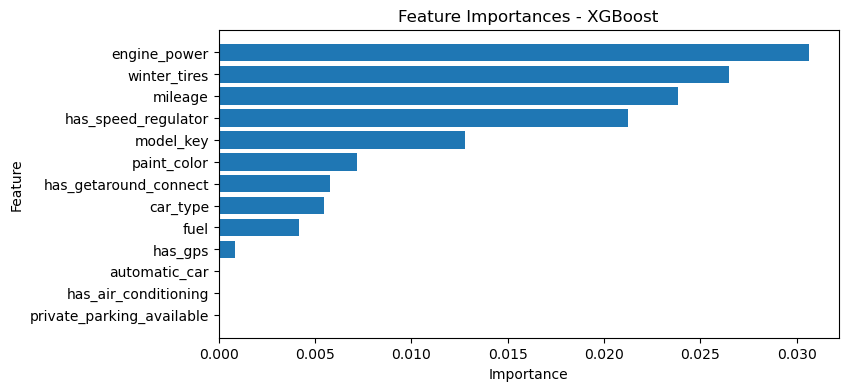

In [356]:
# Features importances

xgboost_model = [result['Best Model'] for result in results if result['Model'] == 'XGBoost'][0]
xgboost_model.fit(X_train, Y_train)
feature_importance = xgboost_model.feature_importances_
# Convert the sparse matrix to a dense matrix
X_train_dense = X_train.toarray()
original_feature_importance = feature_importance[:13]
feature_importance_df = pd.DataFrame({'Feature': features_list, 'Importance': original_feature_importance})
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
sorted_feature_importance = sorted_feature_importance_df['Importance'].values
sorted_feature_names = sorted_feature_importance_df['Feature'].values

# Plot the sorted feature importance
plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importances - XGBoost')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.show()